<a href="https://colab.research.google.com/github/micah-shull/LLMs/blob/main/LLM_035_fine_tuning_yahoo_answers_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMDB Dataset from HuggingFace
---

The IMDB dataset is a widely-used benchmark dataset for sentiment analysis. It consists of 50,000 movie reviews, each labeled as either **positive** or **negative**. The dataset is balanced, with an equal number of positive and negative reviews, making it ideal for binary text classification tasks.

### **Key Features of the IMDB Dataset:**
- **Size:** 50,000 movie reviews (25,000 for training and 25,000 for testing).
- **Labels:**
  - `1` for positive sentiment.
  - `0` for negative sentiment.
- **Use Case:** Sentiment analysis – determining the polarity (positive/negative) of text.
- **Source:** Hugging Face `datasets` library, which provides seamless integration for loading and preprocessing.

### **Objective:**
In this notebook, we will:
1. Load and explore the IMDB dataset using the Hugging Face `datasets` library.
2. Tokenize the text data for input into a transformer model.
3. Convert the dataset into a format compatible with Hugging Face models.
4. Fine-tune a pre-trained transformer model (e.g., `distilbert-base-uncased`) for sentiment analysis.
5. Evaluate the model's performance on the test set.



#### Load & Import Libraries

In [2]:
# !pip install transformers datasets
# !pip install python-dotenv

In [5]:
# Hugging Face Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Standard Libraries
import pandas as pd
import numpy as np
import os
import time
import json
from dotenv import load_dotenv

# Metrics and Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Load  Data

In [16]:
from huggingface_hub import login

# Load environment variables
load_dotenv('/content/API_KEYS.env')
hugginface_api_key = os.getenv("HUGGINGFACE_API_KEY")
# Log in using the Hugging Face API key
login(token=hugginface_api_key)
# os.environ["HF_TOKEN"] = hugginface_api_key
# print("HUGGINFACE API Key loaded from .env:",os.environ["HF_TOKEN"][0:10])

# Load the dataset
dataset = load_dataset("imdb")

# Inspect the dataset structure
print(dataset)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


### Visualize Data Distribution

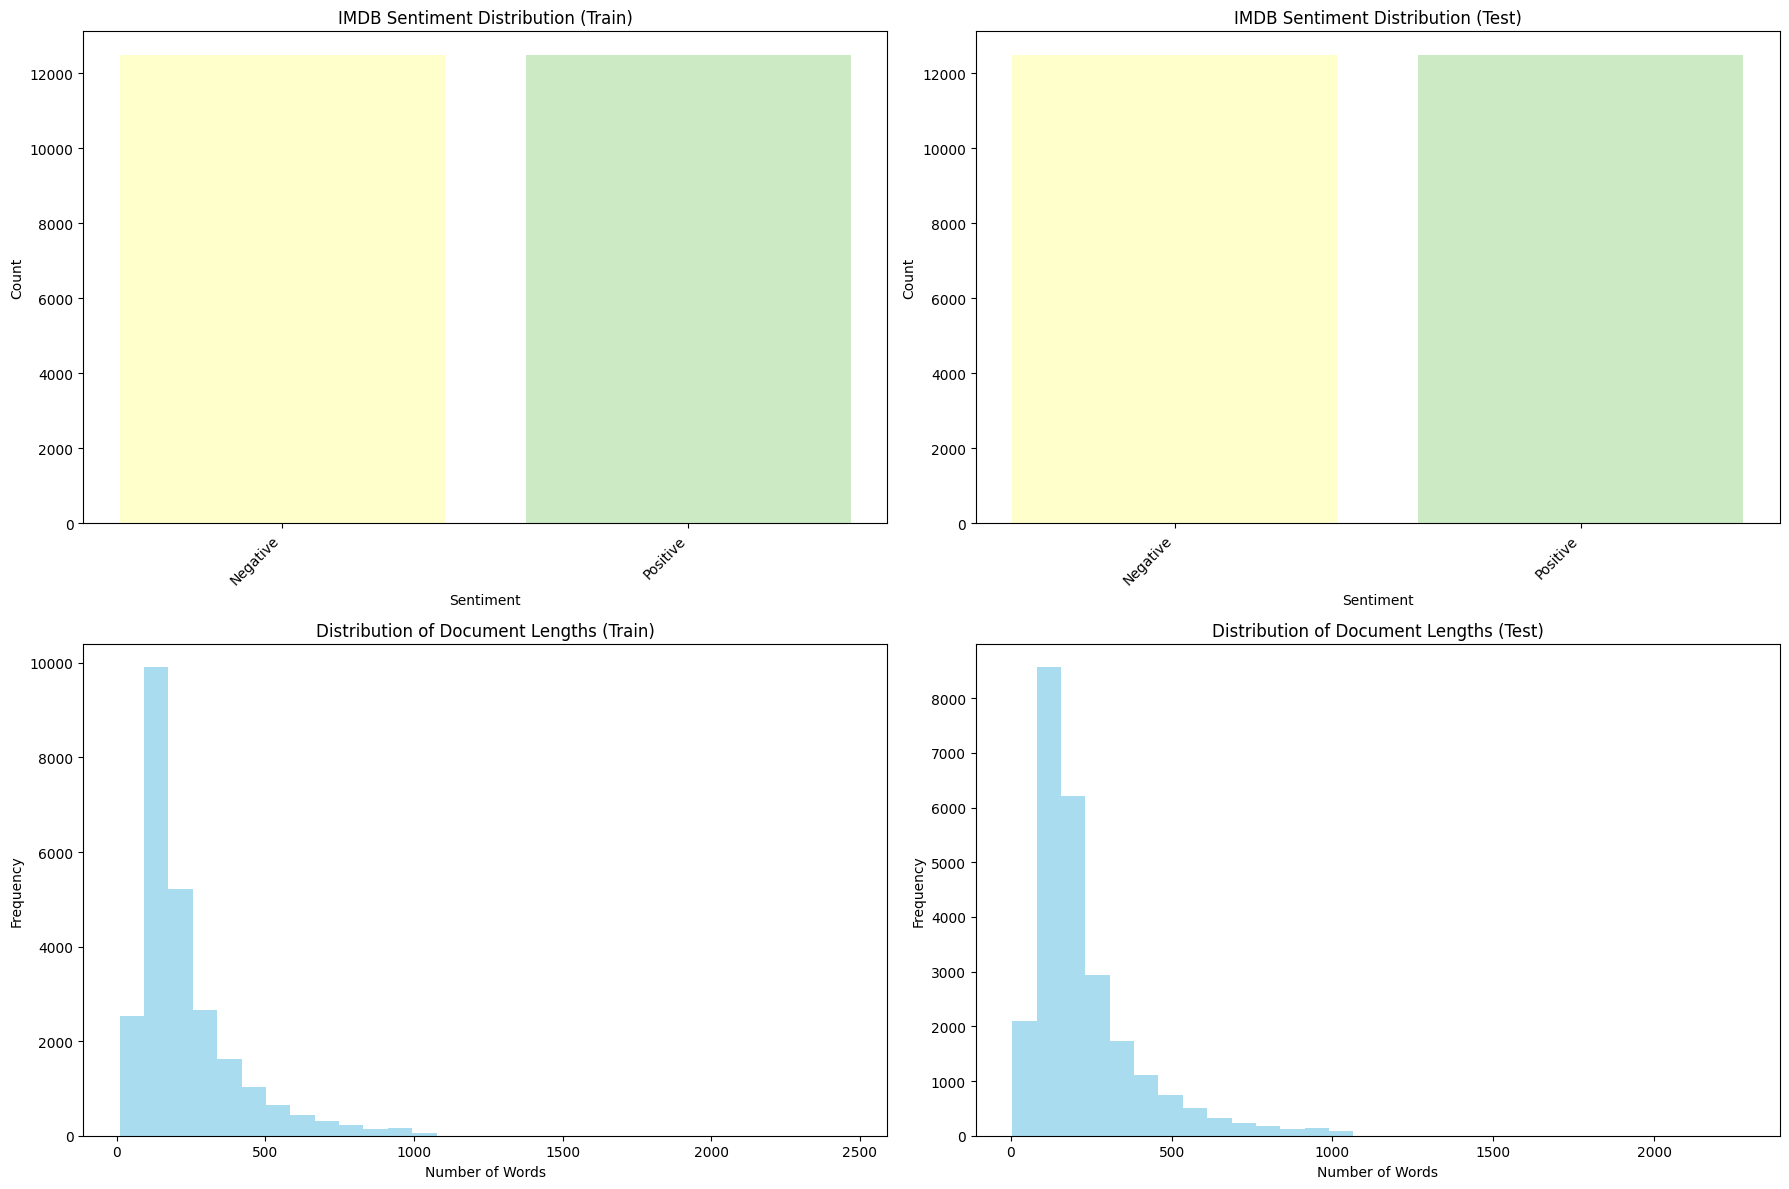

Train Document Length Statistics:
Mean Length: 233.7872
Max Length: 2470
Min Length: 10

Test Document Length Statistics:
Mean Length: 228.52668
Max Length: 2278
Min Length: 4


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the label names
label_names = ["Negative", "Positive"]

# Calculate value counts for labels for train and test datasets
train_label_counts = pd.Series(dataset['train']['label']).value_counts().sort_index()
test_label_counts = pd.Series(dataset['test']['label']).value_counts().sort_index()
train_label_counts.index = label_names  # Map numeric labels to sentiment names
test_label_counts.index = label_names   # Map numeric labels to sentiment names

# Calculate document lengths for train and test datasets
train_document_lengths = [len(text.split()) for text in dataset['train']['text']]
test_document_lengths = [len(text.split()) for text in dataset['test']['text']]

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Set up a color palette
palette = sns.color_palette("Pastel1_r", 2)

# Plot 1: Train Label Distribution
axes[0, 0].bar(train_label_counts.index, train_label_counts.values, color=palette)
axes[0, 0].set_title("IMDB Sentiment Distribution (Train)")
axes[0, 0].set_xlabel("Sentiment")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks(range(len(train_label_counts.index)))
axes[0, 0].set_xticklabels(train_label_counts.index, rotation=45, ha='right')

# Plot 2: Test Label Distribution
axes[0, 1].bar(test_label_counts.index, test_label_counts.values, color=palette)
axes[0, 1].set_title("IMDB Sentiment Distribution (Test)")
axes[0, 1].set_xlabel("Sentiment")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticks(range(len(test_label_counts.index)))
axes[0, 1].set_xticklabels(test_label_counts.index, rotation=45, ha='right')

# Plot 3: Train Document Length Distribution
axes[1, 0].hist(train_document_lengths, bins=30, color='skyblue', alpha=0.7)
axes[1, 0].set_title("Distribution of Document Lengths (Train)")
axes[1, 0].set_xlabel("Number of Words")
axes[1, 0].set_ylabel("Frequency")

# Plot 4: Test Document Length Distribution
axes[1, 1].hist(test_document_lengths, bins=30, color='skyblue', alpha=0.7)
axes[1, 1].set_title("Distribution of Document Lengths (Test)")
axes[1, 1].set_xlabel("Number of Words")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Display basic statistics for train and test document lengths
print("Train Document Length Statistics:")
print("Mean Length:", sum(train_document_lengths) / len(train_document_lengths))
print("Max Length:", max(train_document_lengths))
print("Min Length:", min(train_document_lengths))
print("\nTest Document Length Statistics:")
print("Mean Length:", sum(test_document_lengths) / len(test_document_lengths))
print("Max Length:", max(test_document_lengths))
print("Min Length:", min(test_document_lengths))


## Sample & Format Data

### Why Do We Need to Format the Data for Fine-Tuning?

Fine-tuning a pre-trained language model requires the input data to be structured in a format compatible with the model's architecture and the specific task we want to perform. Here’s why formatting is essential:

---

#### **1. Aligning with the Model's Input Requirements**
Pre-trained models like T5 or GPT-based models expect input in specific formats:
- **T5:** Typically requires a task-specific prefix (e.g., `"sentiment analysis: <text>"`) or a well-structured input-output pair.
- **GPT-style models:** Use conversational formats with distinct roles (`user`, `assistant`, `system`) to guide the model's behavior.

---

#### **2. Task-Specific Context**
The pre-trained model was trained on a broad range of tasks and needs task-specific signals to understand what we’re asking it to do. For example:
- In sentiment analysis, specifying that the task is about determining sentiment helps the model focus on the task rather than generating unrelated responses.

---

#### **3. Structured Labels for Supervised Learning**
The model learns by comparing its output to the labeled "ground truth." Formatting ensures:
- Inputs (e.g., a movie review) are clearly separated from outputs (e.g., "Positive" or "Negative").
- Labels are accessible to compute loss and guide the model during training.


In [18]:
# Define the label names
label_names = ["Negative", "Positive"]

# Print the original dataset sizes
print("Original dataset sizes:")
print("Train:", len(dataset["train"]))
print("Test:", len(dataset["test"]))

# Sample 10% of the original train and test datasets
train_sample = dataset["train"].train_test_split(test_size=0.1)["test"]  # Keep 10% of the training set
test_sample = dataset["test"].train_test_split(test_size=0.1)["test"]    # Keep 10% of the test set

# Print the sampled dataset sizes
print("\nSampled dataset sizes (10% of original sets):")
print("Sampled Train:", len(train_sample))
print("Sampled Test:", len(test_sample))

# Display the first few entries in the sampled dataset
for i in range(3):
    print(f"\nSample {i+1}:")
    print("Review Text:", train_sample["text"][i])
    print("Sentiment Label:", label_names[train_sample["label"][i]])
    print("=" * 50)

# Print the first entry of train and test datasets to inspect their structure
import json

print("\nTrain Sample:")
print(json.dumps(train_sample[0], indent=2))

print("\nTest Sample:")
print(json.dumps(test_sample[0], indent=2))

# Define a function to format the data into roles for fine-tuning
def format_for_fine_tuning(dataset_sample):
    formatted_data = []

    for i in range(len(dataset_sample)):
        review = dataset_sample[i]["text"]
        label = label_names[dataset_sample[i]["label"]]

        formatted_data.append([
            {"role": "system", "content": "You are a sentiment analysis assistant."},
            {"role": "user", "content": review},
            {"role": "assistant", "content": label}
        ])

    return formatted_data

# Format train and test datasets separately
formatted_train_data = format_for_fine_tuning(train_sample)
formatted_test_data = format_for_fine_tuning(test_sample)

# Print a sample formatted entry from train and test data to inspect the structure
print("Train Sample Entry:")
print(json.dumps(formatted_train_data[0], indent=2))

print("\nTest Sample Entry:")
print(json.dumps(formatted_test_data[0], indent=2))

# Save the formatted data to JSONL files
def save_to_jsonl(data, filename):
    with open(filename, 'w') as f:
        for entry in data:
            f.write(json.dumps(entry) + '\n')

# Save train and test data separately
save_to_jsonl(formatted_train_data, "formatted_imdb_train.jsonl")
save_to_jsonl(formatted_test_data, "formatted_imdb_test.jsonl")

print("\nFormatted data saved to JSONL files.")


Original dataset sizes:
Train: 25000
Test: 25000

Sampled dataset sizes (10% of original sets):
Sampled Train: 2500
Sampled Test: 2500

Sample 1:
Review Text: In Le Million, Rene Clair, one of the cinema's great directors and great pioneers, created a gem of light comedy which for all its lightness is a groundbreaking and technically brilliant film which clearly influenced subsequent film-makers such as the Marx Brothers, Lubitsch, and Mamoulian. The plot, a witty story of a poor artist who wins a huge lottery jackpot but has to search frantically all over town for the missing ticket, is basically just a device to support a series of wonderfully witty comic scenes enacted in a dream world of the director's imagination.<br /><br />One of the most impressive things about this film is that, though it is set in the middle of Paris and includes nothing actually impossible, it achieves a sustained and involving fairy-tale/fantasy atmosphere, in which it seems quite natural that people sing a

#### Class Distribution after Sampling

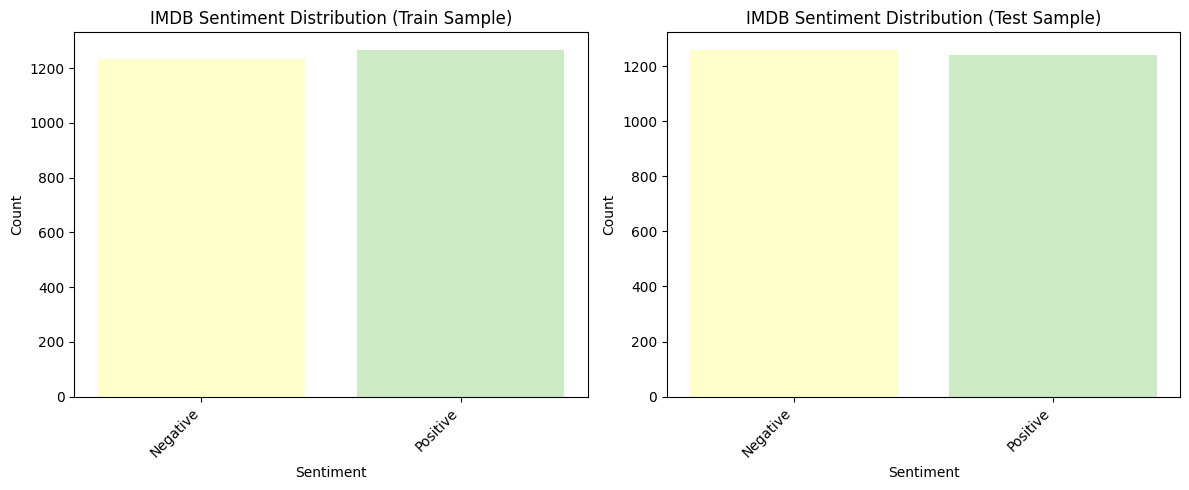

Train Label Distribution:
Negative    1233
Positive    1267
Name: count, dtype: int64

Test Label Distribution:
Negative    1260
Positive    1240
Name: count, dtype: int64


In [29]:
# Print the first five entries of the formatted train data
# print("First 5 entries of formatted train data:")
# for i in range(5):
#     print(formatted_train_data[i])

# # Print the first five entries of the formatted test data
# print("\nFirst 5 entries of formatted test data:")
# for i in range(5):
#     print(formatted_test_data[i])

# Calculate value counts for labels in sampled train and test datasets
train_label_counts = pd.Series(train_sample['label']).value_counts().sort_index()
test_label_counts = pd.Series(test_sample['label']).value_counts().sort_index()

# Map numeric labels to sentiment names
train_label_counts.index = label_names
test_label_counts.index = label_names

# Create a 1x2 grid for the label distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Set up a color palette
palette = sns.color_palette("Pastel1_r", 2)

# Plot 1: Train Label Distribution
axes[0].bar(train_label_counts.index, train_label_counts.values, color=palette)
axes[0].set_title("IMDB Sentiment Distribution (Train Sample)")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(train_label_counts.index)))
axes[0].set_xticklabels(train_label_counts.index, rotation=45, ha='right')

# Plot 2: Test Label Distribution
axes[1].bar(test_label_counts.index, test_label_counts.values, color=palette)
axes[1].set_title("IMDB Sentiment Distribution (Test Sample)")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Count")
axes[1].set_xticks(range(len(test_label_counts.index)))
axes[1].set_xticklabels(test_label_counts.index, rotation=45, ha='right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Print the numeric distribution for verification
print("Train Label Distribution:")
print(train_label_counts)

print("\nTest Label Distribution:")
print(test_label_counts)


## Tokenize the Data

In [24]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define a function to tokenize the data entries
def tokenize_data(entry):
    # Extract review text and label
    review_text = entry["text"]  # Review text
    label = entry["label"]       # Sentiment label (0 or 1)

    # Tokenize the review text
    tokenized_output = tokenizer(review_text, padding="max_length", truncation=True, max_length=128)

    # Add the label to the tokenized output
    tokenized_output["labels"] = label

    # Convert BatchEncoding to a dictionary
    return {key: value for key, value in tokenized_output.items()}

# Save tokenized data to JSONL
def save_tokenized_data(tokenized_data, filepath):
    with open(filepath, "w") as f:
        for entry in tokenized_data:
            f.write(json.dumps(entry) + "\n")

# Tokenize and save train data
tokenized_train_data = [tokenize_data(entry) for entry in train_sample]
save_tokenized_data(tokenized_train_data, "tokenized_imdb_train.jsonl")

# Tokenize and save test data
tokenized_test_data = [tokenize_data(entry) for entry in test_sample]
save_tokenized_data(tokenized_test_data, "tokenized_imdb_test.jsonl")

# Print the first tokenized train data entry to verify
print("First tokenized train data entry:")
print(tokenized_train_data[0])

print("First tokenized test data entry:")
print(tokenized_test_data[0])

# Check the structure of the data
print("\nTraining Dataset Sample:\n", pd.DataFrame(tokenized_train_data).head(10))
print("\nTest Dataset Sample:\n", pd.DataFrame(tokenized_test_data).head(10))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

First tokenized train data entry:
{'input_ids': [101, 1999, 3393, 2454, 1010, 10731, 17936, 1010, 2028, 1997, 1996, 5988, 1005, 1055, 2307, 5501, 1998, 2307, 13200, 1010, 2580, 1037, 17070, 1997, 2422, 4038, 2029, 2005, 2035, 2049, 2422, 2791, 2003, 1037, 23222, 1998, 10892, 8235, 2143, 2029, 4415, 5105, 4745, 2143, 1011, 11153, 2107, 2004, 1996, 13518, 3428, 1010, 11320, 16313, 11624, 1010, 1998, 5003, 5302, 20922, 2078, 1012, 1996, 5436, 1010, 1037, 25591, 2466, 1997, 1037, 3532, 3063, 2040, 5222, 1037, 4121, 15213, 2990, 11008, 2021, 2038, 2000, 3945, 16460, 2035, 2058, 2237, 2005, 1996, 4394, 7281, 1010, 2003, 10468, 2074, 1037, 5080, 2000, 2490, 1037, 2186, 1997, 6919, 2135, 25591, 5021, 5019, 11955, 1999, 1037, 3959, 2088, 1997, 1996, 2472, 1005, 1055, 9647, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Converting your tokenized data to a Hugging Face `Dataset` is an important step for several reasons, especially if you're planning to use Hugging Face’s `Trainer` API for model fine-tuning. Let’s break down this step and why it’s useful.

### Convert to a Hugging Face Dataset

1. **Compatibility with Hugging Face Trainer**: Hugging Face's `Trainer` class expects the training and evaluation data to be in the form of a `Dataset` (from the `datasets` library). This format allows seamless integration with the `Trainer` API, making it straightforward to define and run training, evaluation, and even tokenized data manipulation.

2. **Efficiency and Scalability**: Hugging Face's `Dataset` object is optimized for large-scale datasets, enabling efficient handling of in-memory and memory-mapped data. It’s designed to handle transformations, batching, shuffling, and slicing efficiently, especially when working with large volumes of tokenized data.

3. **Preprocessing Flexibility**: The `Dataset` object provides easy methods for on-the-fly transformations, such as tokenization or data augmentation. It’s very flexible, allowing you to apply these transformations directly to each entry while maintaining an efficient workflow.

4. **Integration with Data Collators and Tokenizers**: When you load tokenized data into a `Dataset` object, you can leverage Hugging Face’s data collators, which are utilities that help pad and batch the data dynamically. This step makes the data ready for model consumption without manually adjusting batch sizes or paddings.



In [25]:
from datasets import load_dataset, DatasetDict

# Load the tokenized train and test datasets directly from JSONL
train_dataset = load_dataset("json", data_files="tokenized_imdb_train.jsonl")["train"]
test_dataset = load_dataset("json", data_files="tokenized_imdb_test.jsonl")["train"]

# Combine train and test datasets into a DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Verify the dataset structure
print(dataset_dict)

# Inspect a few samples
print("Training Dataset Sample:\n", train_dataset.select(range(10)))
print("\nTest Dataset Sample:\n", test_dataset.select(range(10)))



Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2500
    })
})
Training Dataset Sample:
 Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10
})

Test Dataset Sample:
 Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10
})


## Tune the Model















### Load the Pretrained Model
**Recommended Pre-trained Models for Sentiment Analysis on IMDB : DistilBERT**
- **Model Name:** `distilbert-base-uncased`
- **Why Choose It:**
  - Lightweight and fast, making it suitable for smaller datasets like IMDB.
  - Requires less computational power compared to larger models.
  - Maintains strong performance on text classification tasks.
- **Use Case:** Ideal for quick experiments and limited computational resources.

### **Recommendation: Start with DistilBERT**
- **Why?**
  - It’s efficient and fast, which is great for learning and experimentation.
  - Fine-tunes well on smaller datasets like IMDB.
  - Provides a good balance between accuracy and resource consumption.




### Define Training Arguments and Train



In [26]:
from transformers import AutoModelForSequenceClassification

# Load a pre-trained DistilBERT model for sentiment analysis
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 labels: Negative and Positive

# Verify the model structure
print(model)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [27]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import os
import time

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load a small pre-trained DistilBERT model for sequence classification
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 labels: Negative and Positive

# Reduce dataset size for faster training
small_train_dataset = dataset_dict["train"].shuffle(seed=42).select(range(100))  # Use only 100 samples
small_test_dataset = dataset_dict["test"].shuffle(seed=42).select(range(20))     # Use only 20 samples

# Define training arguments optimized for speed
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="no",           # Disable evaluation during training
    learning_rate=5e-5,                 # Use a slightly higher learning rate for faster convergence
    per_device_train_batch_size=8,      # Reduce batch size to save memory and speed up
    num_train_epochs=1,                 # Train for only one epoch
    logging_steps=10,                   # Reduce logging frequency
    fp16=True,                          # Use mixed precision for faster training (if supported by hardware)
    save_total_limit=1,                 # Save fewer checkpoints
    report_to="none"                    # Disable W&B logging
)

# Define a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
)

# Start the timer
start_time = time.time()

# Start training
trainer.train()

# End the timer and calculate duration
end_time = time.time()
duration = (end_time - start_time) / 60  # Convert seconds to minutes
print(f"Training completed in {duration:.2f} minutes.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.687900


Training completed in 2.19 minutes.


This warning is normal and expected when you load a pre-trained model like `distilbert-base-uncased` for a new task (e.g., sequence classification). Here’s why it happens and what you should do:

---

#### **Why Does This Warning Appear?**
1. **Uninitialized Layers:**
   - The `distilbert-base-uncased` model is pre-trained on a generic language modeling task, but it doesn't include task-specific layers like the classification head (`classifier` and `pre_classifier` layers).
   - When you specify `num_labels=2`, the Hugging Face library adds a new classification head to the model, which is randomly initialized.

2. **Purpose of the Warning:**
   - It's a reminder that you need to **fine-tune** the model on your specific task (e.g., sentiment analysis) for the new layers to be properly trained.

---

### **Should You Do Anything About It?**
You don’t need to suppress the warning or make any changes to the model. The fine-tuning process you're performing is designed to:
- Train the new classification head (randomly initialized layers).
- Adjust the pre-trained weights slightly for your specific task (IMDB sentiment analysis).

**The warning is informative but harmless. It indicates you're doing the correct steps.**


### Evaluate Model

In [28]:
from sklearn.metrics import classification_report

# Evaluate the model and get predictions
predictions = trainer.predict(small_test_dataset)

# Extract logits and predicted class labels
logits = predictions.predictions
predicted_labels = logits.argmax(axis=-1)  # Convert logits to predicted class labels

# Extract true labels
true_labels = predictions.label_ids

# Generate the classification report
label_names = ["Negative", "Positive"]  # Map numeric labels to descriptive names
report = classification_report(true_labels, predicted_labels, target_names=label_names, zero_division=0)

# Print the classification report
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        10
    Positive       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20

